# Notebook 2: Cleaning, Wrangling, and Visualizing Outputs from AWS Transcribe

In this notebook, we will take the transcripts generated in the previous notebook, extract the data in which we are interested, and create visualizations to more easily understand Amazon Transcribe's accuracy.

## Import Data
We have fifteen transcripts across five accents and three levels of text difficulty stored in our S3 bucket, **aws-generated-transcripts**. We retrieve them by calling to S3 and assign them to object names for simplification. You can replace our bucket name with the one you used in the previous notebook, or you can simply call from our output bucket.

In [1]:
import boto3
s3 = boto3.resource('s3')

In [2]:
amerEasy = s3.Object('aws-generated-transcripts','American_Easy_Transcript.json')
amerMed = s3.Object('aws-generated-transcripts','American_Medium_Transcript.json')
amerHard = s3.Object('aws-generated-transcripts','American_Hard_Transcript.json')

britEasy = s3.Object('aws-generated-transcripts','British_Easy_Transcript.json')
britMed = s3.Object('aws-generated-transcripts','British_Medium_Transcript.json')
britHard = s3.Object('aws-generated-transcripts','British_Hard_Transcript.json')

chinEasy = s3.Object('aws-generated-transcripts','Chinese_Easy_Transcript.json')
chinMed = s3.Object('aws-generated-transcripts','Chinese_Medium_Transcript.json')
chinHard = s3.Object('aws-generated-transcripts','Chinese_Hard_Transcript.json')

hindiEasy = s3.Object('aws-generated-transcripts','Hindi_Easy_Transcript.json')
hindiMed = s3.Object('aws-generated-transcripts','Hindi_Medium_Transcript.json')
hindiHard = s3.Object('aws-generated-transcripts','Hindi_Hard_Transcript.json')

spanEasy = s3.Object('aws-generated-transcripts','Spanish_Easy_Transcript.json')
spanMed = s3.Object('aws-generated-transcripts','Spanish_Medium_Transcript.json')
spanHard = s3.Object('aws-generated-transcripts','Spanish_Hard_Transcript.json')

We also need to retrieve the actual transcripts from our bucket, **actual-transcripts-for-comparison**, done below:

In [3]:
actual_Easy = s3.Object('actual-transcripts-for-comparison','Easy_Actual_Transcription.txt')
easy_actual_str = actual_Easy.get()['Body'].read().decode('utf-8')
actual_Med = s3.Object('actual-transcripts-for-comparison','Medium_Actual_Transcription.txt')
med_actual_str = actual_Easy.get()['Body'].read().decode('utf-8')
actual_Hard = s3.Object('actual-transcripts-for-comparison','Hard_Actual_Transcription.txt')
hard_actual_str = actual_Easy.get()['Body'].read().decode('utf-8')

## Data Structure
First, let's understand the structure of our data. By default, Transcribe returns a [JSON](https://www.json.org/json-en.html) file. JSON stands for JavaScript Object Notation, and it is a lightweight way of transferring data between a browser (such as Google Chrome) and a server (such as those that house and run AWS services). JSON files have little structure, and can be difficult to read. Fortunately, a JSON file can be easily converted into a Python [dictionary](https://realpython.com/python-dicts/) with the `json.loads()` function. Once we have the Python dictionary, its structure can still be complex. Thus, the diagram below is shown to more clearly indicate which variables we are interested in.

<img src="https://docs.google.com/uc?export=download&id=1hmTkvp6NoU_WtL0zOO_pbNROoj-peGOD">

In the diagram, solid lines indicate Python dictionaries, and dashed lines indicate Python lists. The data we're interested in is highlighted in turquoise. Obviously, we are interested in the transcript itself, as we would like to make comparisons of its text to the actual texts. We are also interested in two more variables, `content` and `confidence`. For each element transcribed (punctuation is parsed separately from the words themselves), AWS Transcribe reports its transcription of that word or punctuation is, along with its confidence in its transcription of that element. Thus, in the `results` dictionary, `items` is a list containing one dictionary for each word. Each of these dictionaries in turn contain `alternatives`, which contain the `content` and `confidence` variables.

Therefore, if we want to see, say, the confidence level for the second word in a transcript, we would use the following code (Remember, Python uses zero-based indexing!):  
`transcript_name['results']['items'][1]['alternatives'][0]['confidence']`  

Of course, this would be very tedious to do for each and every word, especially considering that we have fifteen transcripts to examine! This is where we turn to functions, not only to load our datasets and extract the information we want, but also to manipulate them in ways that facilitate our visualizations.

## Data Analysis
Now we can start analyzing our data. Since we want to find out the same information about all of our transcripts, we'll create functions, the first of which will return the Levenshtein Distance between the AWS transcript and actual transcript. You may need to install the python-Levenshtein package.

In [2]:
import json
import pandas as pd
!pip install python-Levenshtein
import Levenshtein

     |████████████████████████████████| 48 kB 7.0 MB/s  eta 0:00:01
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=151448 sha256=dcf38f14c598807c08fcac4873844eb46d1e0963ded59a5ff6a1a07af4e20de0
  Stored in directory: /home/ec2-user/.cache/pip/wheels/79/c3/a1/cbdd8b154234b3e571d121b65be7d53354cc77e223e8f271c8
Successfully built python-Levenshtein
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


### Function 1: Levenshtein Distance
The Levenshtein Distance reflects the number of single-character changes required to make one string match another. We will determine accuracy using this metric, that is, an AWS-generated transcript with a lower Levenshtein distance will be deemed more accurate, for the purposes of this project. It is worth mentioning that AWS Transcribe claims to be able to account for punctuation, so we will leave punctuation in all transcripts for now.

In [5]:
def getLevDist (obj):
    ## Reads in a transcript object, converts it to a dictionary, and extracts the transcript portion
    ## Then compares generated transcript with the corresponding actual transcript, obtaining the Levenshtein Distance
    ## Finally, compiles the accent of the transcript file, the text difficulty, and the Levenshtein Distance in a pandas DataFrame
    ## Returns the created data frame
    
    content_str = obj.get()['Body'].read().decode('utf-8')    # Reads in the file as a string
    content_json = json.loads(content_str)                    # Converts the string to a dictionary
    transcript_str = content_json['results']['transcripts'][0]['transcript']    # Extracts only the transcript itself as a string

    ## For clarity, we're adding this code to remind us of the accent and difficulty of the input transcript.
    ## Determine text level:
    if "Easy" in str(obj):
        actual_str = easy_actual_str
        textlevel = "Easy"
    if "Med" in str(obj):
        actual_str = med_actual_str
        textlevel = "Medium"
    if "Hard" in str(obj):
        actual_str = hard_actual_str
        textlevel = "Hard"
    ## Determine accent:    
    if "Amer" in str(obj):
        speaker = "American_US"
    if "Brit" in str(obj):
        speaker = "British_UK"
    if "Chin" in str(obj):
        speaker = "Chinese"
    if "Hindi" in str(obj):
        speaker = "Hindi"
    if "Span" in str(obj):
        speaker = "Spanish"
    
    ## Obtain the Levenshtein Distance
    levDist = Levenshtein.distance(transcript_str, actual_str)
    
    ## And compile the data, converting it to a pandas data frame.
    df_results = pd.DataFrame({"Accent":[speaker],
                               "Difficulty":[textlevel],
                               "Lev Distance":[levDist]})
    
    ## Returns pandas data frame
    return(df_results)

With our function complete, we can apply it to all of our transcripts. A `for` loop allows us to efficiently compile the resulting data from all transcripts. We will also save our data frame to a CSV file in one of our S3 buckets. (If you wish to save your output, you will again need to provide the name of one of your own S3 buckets.)

In [6]:
dataList = [amerEasy, amerMed, amerHard, britEasy, britMed, britHard, chinEasy, chinMed, chinHard,
           hindiEasy, hindiMed, hindiHard, spanEasy, spanMed, spanHard]    # List for the 'for' loop to cycle through
levData = pd.DataFrame()     # Empty data frame to store outputs as they are created

for dataset in dataList:     # Generating and storing data
    levData = levData.append(getLevDist(dataset))

In [7]:
# Save to CSV and upload to S3
levData.to_csv('LevData.csv', index=False)
s3.meta.client.upload_file('LevData.csv', 'aws-generated-transcripts', 'Lev-Distances.csv')

### Function 2: Word Confidences and Lengths
Our second function will extract each word in the transcript and the corresponding confidence level. We will also calculate the length of each word and clean the data, removing any punctuation and converting all words to lowercase.

In [8]:
def getConfAndLength(obj):
    ## Reads in a transcript object, converts it to a dictionary, and extracts the items portion
    ## Determines and stores accent and text level for clarity
    ## Extracts and stores each word and its confidence level
    ## Removes irrelevant data such as punctuation, and converts all words to lowercase letters
    ## Calculates and stores the length of each word
    ## Returns the data frame with all aforementioned variables
    
    content_str = obj.get()['Body'].read().decode('utf-8')    # Reads in the file as a string
    content_json = json.loads(content_str)                    # Converts the string to a dictionary
    results_list = content_json['results']['items']           # Extracts the 'items' list, containing the dictionaries for all words/elements
    
    ## Create data frame to store relevant data
    working_df = pd.DataFrame(columns = ['accent', 'difficulty', 'confidence', 'content'])
    
    ## Determine test level:
    if "Easy" in str(obj):
        textlevel = "Easy"
    if "Med" in str(obj):
        textlevel = "Medium"
    if "Hard" in str(obj):
        textlevel = "Hard"
    ## Determine accent:   
    if "Amer" in str(obj):
        speaker = "American_US"
    if "Brit" in str(obj):
        speaker = "British_UK"
    if "Chin" in str(obj):
        speaker = "Chinese"
    if "Hindi" in str(obj):
        speaker = "Hindi"
    if "Span" in str(obj):
        speaker = "Spanish"
    
    ## Extract each word and corresponding confidence, adding all to the data frame:
    alternatives_list = []
    for element in results_list:
        alts = element['alternatives'][0]
        alternatives_list.append(alts)
    for i in alternatives_list:
        working_df = working_df.append(i, ignore_index = True)
        
    ## Filter out non-alphanumeric entries and convert all remaining entries to lowercase:
    working_df = working_df.loc[working_df['content'].str.isalnum()]
    working_df['content'] = working_df['content'].str.lower()
    
    ## Obtain word length of all entries:
    contentList = working_df['content'].tolist()
    lengthList = []
    for i in contentList:
        lengthList.append(len(i))
    working_df['wrdLength'] = lengthList
    
    ## Add appropriate accent/difficulty labels to data
    working_df['difficulty'] = [textlevel] * len(working_df.index)
    working_df['accent'] = [speaker] * len(working_df.index)
    
    ## Convert confidence column from str to float64
    working_df = working_df.astype({'confidence':'float64'})
    
    ## Returns pandas data frame
    return(working_df)

Additionally, since the JSON files are read in as strings, therefore making all of the values we extracted strings as well, we add a line of code at the end of our function to convert the `confidence` column from type `str` to type `float64` so that we can work with this column's data as numbers. 

In [9]:
confLenData = pd.DataFrame()     # Empty data frame for storage

for dataset in dataList:     # Generating and storing data
    confLenData = confLenData.append(getConfAndLength(dataset))

In [10]:
# Save to CSV and upload to S3
confLenData.to_csv('confLenData.csv', index=False)
s3.meta.client.upload_file('confLenData.csv', 'aws-generated-transcripts', 'Word-Confidences-and-Lengths.csv')

## Visualize Data
We are interested in seeing if Transcribe's accuracy varies across different accents speaking the same English words. We also would like to know if longer words correlate with lower confidence levels from Transcribe. The following figures give a more intuitive portrayal of our data.

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

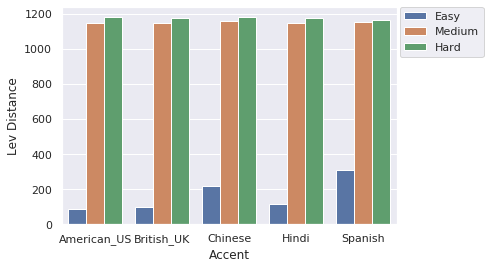

In [12]:
sns.set(font_scale=1)
sns.barplot(x="Accent", y="Lev Distance", hue="Difficulty", data=levData)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

Here, we can see that Transcribe was most accurate in transcribing the "Easy" audio files, but had about the same level of accuracy when it came to transcribing the "Medium" and "Hard" transcripts.

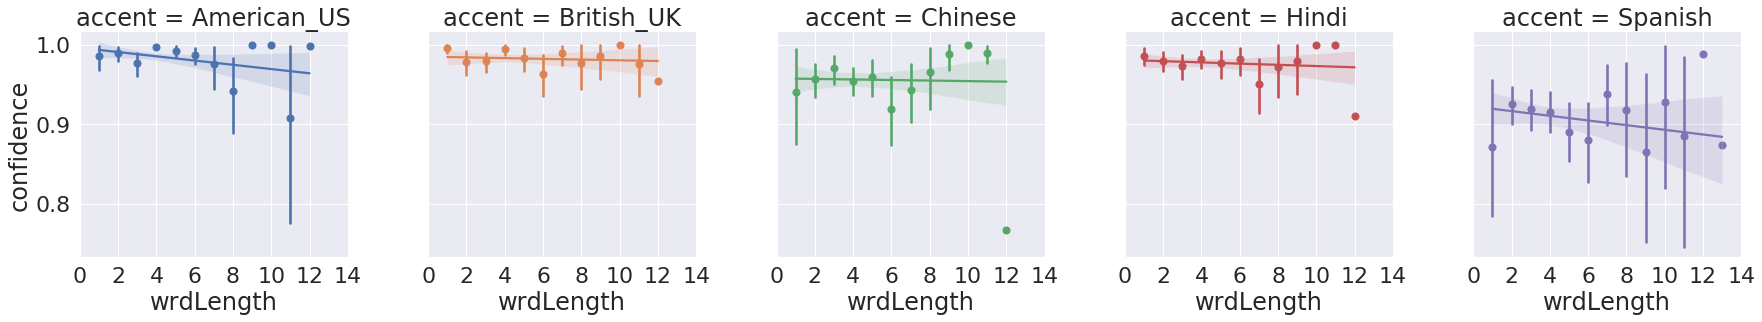

In [13]:
sns.set(font_scale=2)
viz=sns.lmplot(data=confLenData, x="wrdLength", y="confidence",
    col="accent", hue="accent", x_estimator=np.mean);

plt.xlim([0,14])
plt.xticks(np.arange(0,15,step=2))
plt.subplots_adjust(wspace = 0.3)

These figures reveal a *very* slight negative correlation between word length and confidence level. We also notice that in general, confidence levels seem to be lowest regarding the Spanish accent.

In [14]:
confLenData.groupby(['accent','difficulty']).mean().sort_values(by=['confidence'],ascending=False)

,,confidence,wrdLength
accent,difficulty,,
British_UK,Medium,0.992242,3.813043
American_US,Medium,0.986954,3.821739
Hindi,Medium,0.986548,3.821739
American_US,Easy,0.986209,3.816949
British_UK,Easy,0.981380,3.757475
American_US,Hard,0.979695,5.423841
Hindi,Easy,0.978565,3.766892
Chinese,Hard,0.975869,5.437908
British_UK,Hard,0.972881,5.376623


In [15]:
confLenData.groupby(['accent','difficulty']).std().sort_values(by=['confidence'])

confidence  wrdLength
accent      difficulty                       
British_UK  Medium        0.035875   1.813295
Hindi       Medium        0.055987   1.816580
American_US Medium        0.059448   1.828560
            Easy          0.061874   1.670182
Hindi       Easy          0.070070   1.641533
British_UK  Easy          0.074146   1.622031
American_US Hard          0.075973   2.873876
Chinese     Hard          0.080684   2.823375
British_UK  Hard          0.096461   2.830917
Hindi       Hard          0.102209   2.812665
Chinese     Medium        0.105426   1.882268
            Easy          0.140550   1.602427
Spanish     Medium        0.145678   1.841936
            Hard          0.178665   2.733075
            Easy          0.180134   1.579514

In looking at these tables, it seems that Transcribe was most confident in its transcriptions of the medium-level passages for British (UK), American (US), and Hindi (India) accents. It was the least confident in its transcriptions of the passages spoken with a Spanish accent.

## In Conclusion:
AWS Transcribe is a valuable tool, and handles some accents well, but others not as much. As the world continues to grow more and more connected, and with English continuing to be a prominent language in many countries, it's important that we account for the wide variety of people who speak English and reflect that in our transcription services. 